<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number: 37
# Student 1: Jiong Li | 1533312
# Student 2: Peter Elmers | 1734350
# Student 3: P.T.C.M. Tholhuijsen | 1237447

In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [3]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


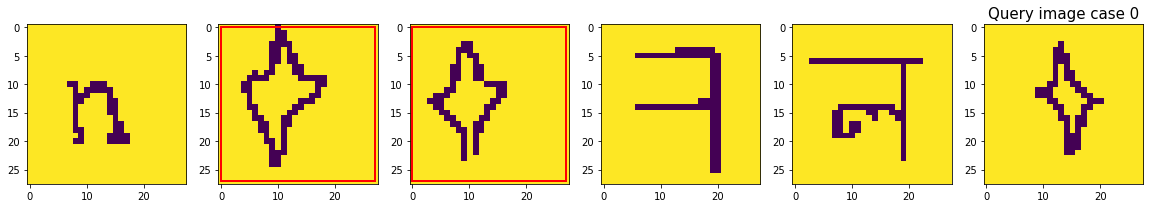

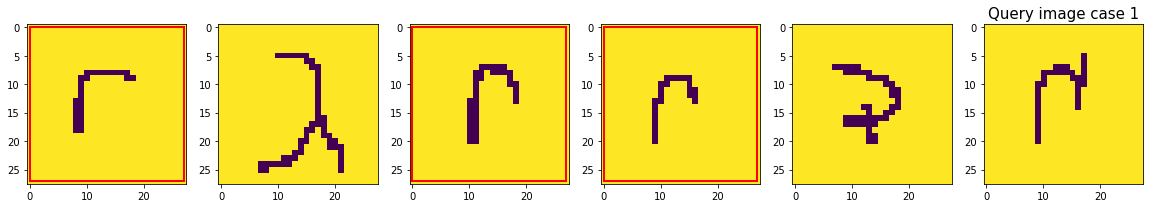

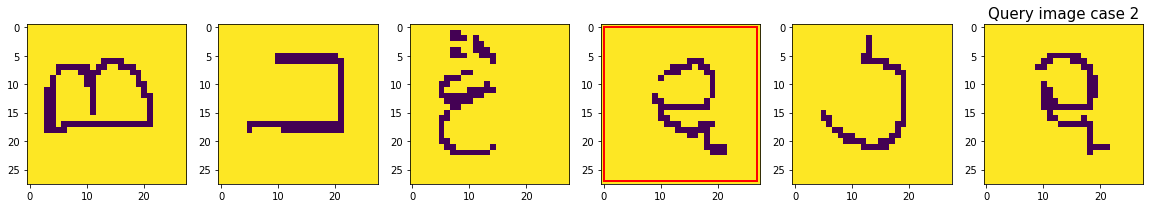

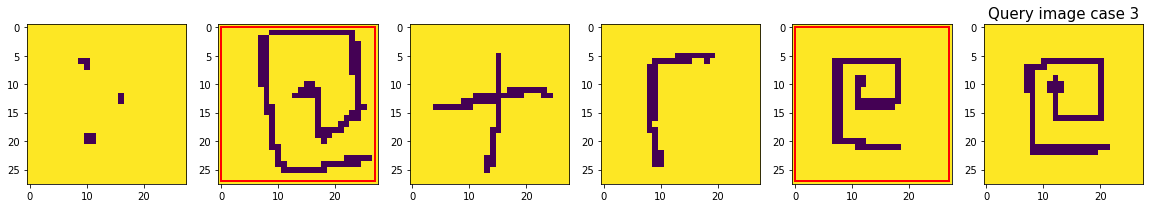

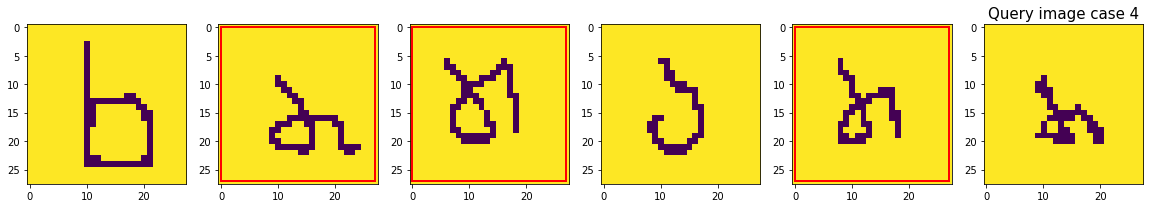

In [4]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [5]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



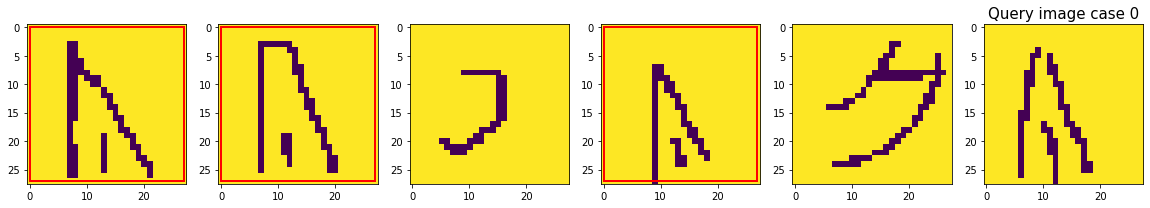

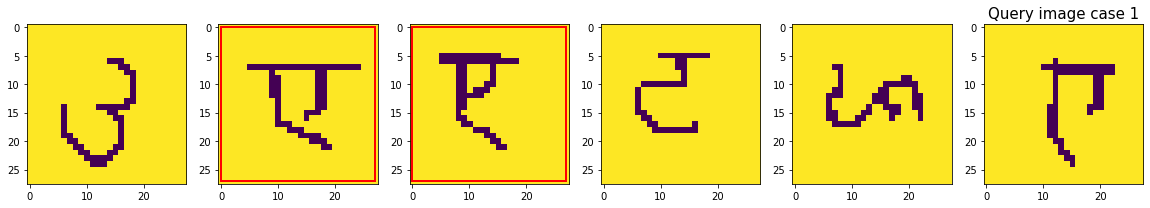

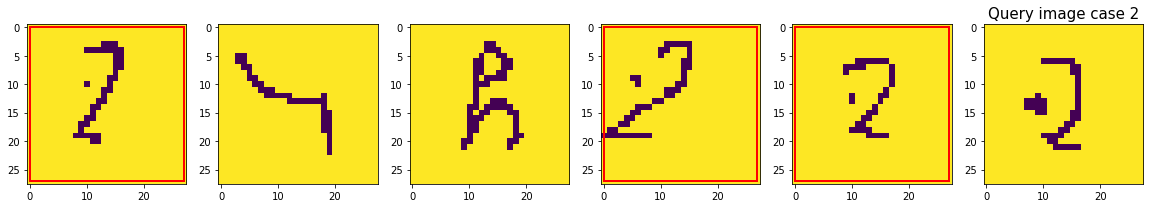

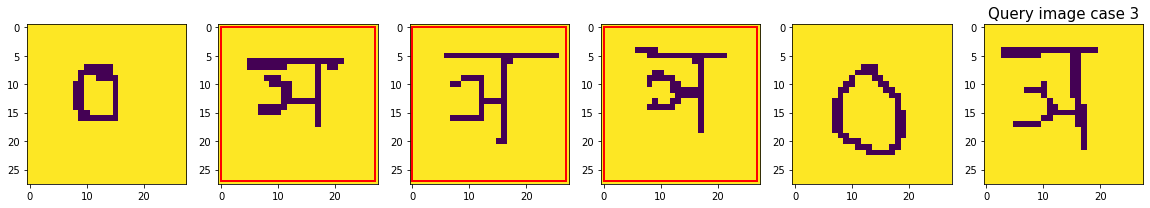

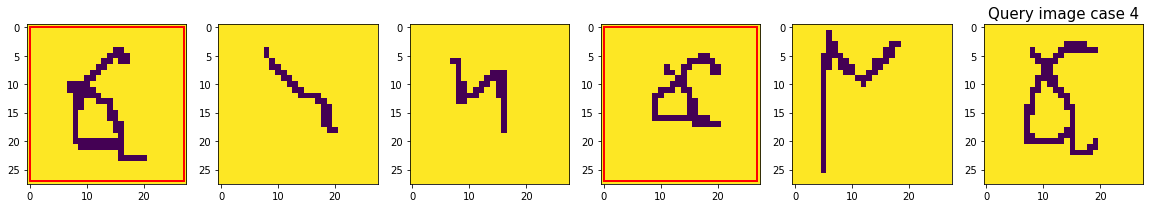

In [6]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [11]:
from sklearn.model_selection import train_test_split
train_data, validation_data, train_label, validation_label = train_test_split(train_data, train_label, test_size=0.2)

In [13]:
# transform = transforms.ToTensor()
train_dataset=MyDataset(train_data,train_label)
validation_dataset=MyDataset(validation_data,validation_label)
test_dataset=MyDataset(test_data,test_label)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

In [15]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=10)

In [16]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [17]:
from tqdm import tqdm

In [18]:
next(iter(train_loader))[0].shape

torch.Size([10, 6, 28, 28])

In [19]:
next(iter(train_loader))[1].shape

torch.Size([10, 5])

In [31]:
for x, y in train_loader:
    print(x)
    print(x.shape)
    print(y)
    print(y.shape)
    break


tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          

In [93]:
# The model
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        
        self.linear = nn.Sequential(
            nn.Linear(256, 1, bias=False),
            nn.Sigmoid()
        )
        
        
    def forward(self, x_a, x_q):
        x_a = torch.unsqueeze(x_a, dim=0)
               
        x_a = self.cnn(x_a)
        x_q = self.cnn(x_q)
                
        dist = nn.functional.l1_loss(x_a, x_q, size_average=False, reduce=False)
        
        return dist
                
model = Model()

In [34]:
# The optimizer
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.1)

In [35]:
# The loss function
loss_func = nn.CrossEntropyLoss()

In [36]:
# Check if the GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    loss_func = loss_func.cuda()

In [133]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    y_pred = list()
    for row_xb, row_yb in zip(xb, yb):
        xb_q = row_xb[-1:]
        for xb_a, yb_a in zip(row_xb[:-1], row_yb):
            y_pred_a = model(xb_a, xb_q)
            y_pred.append(y_pred_a)
    
    yb = yb.to(torch.float32)
    
    print(yb)
    print(y_pred)
    
    for tensor in y_pred:
        tensor.to(dtype=torch.long)
    
    torch.LongTensor(y_pred)
    
    loss = loss_func(y_pred, yb)
    loss = torch.autograd.Variable(loss, requires_grad=True)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [81]:
# Fitting/Training the model
train_loss_list, val_loss_list = list(), list()

def fit(epochs, model, loss_func, train_loader, validation_loader, opt):
    for epoch in tqdm(range(epochs)):
        opt.zero_grad()
        model.train()
        
        running_loss = 0.0
        sample_num=0
        for xb, yb in train_loader:
            if torch.cuda.is_available():
                xb = xb.cuda()
                yb = yb.cuda()                
                
            losses, nums = loss_batch(model, loss_func, xb, yb, opt)
            running_loss += losses * xb.size(0)
            sample_num += nums
            
        train_loss = running_loss / sample_num
        train_loss_list.append(train_loss)
            
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            sample_num=0
            for xb, yb in validation_loader:
                if torch.cuda.is_available():
                    xb = xb.cuda()
                    yb = yb.cuda()
                
                losses, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                sample_num += nums
                                
            val_loss = running_loss / sample_num
            val_loss_list.append(val_loss)
                
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}", end="\n")
                

In [134]:
epochs = 10
fit(epochs, model, loss_func, train_loader, validation_loader, optimizer)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 0.]], device='cuda:0')


  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

[tensor([[[0.0037]],

        [[0.0000]],

        [[0.0194]],

        [[0.0168]],

        [[0.0076]],

        [[0.0000]],

        [[0.0189]],

        [[0.0118]],

        [[0.0000]],

        [[0.0000]],

        [[0.0092]],

        [[0.0000]],

        [[0.0111]],

        [[0.0000]],

        [[0.0000]],

        [[0.0053]],

        [[0.0000]],

        [[0.0000]],

        [[0.0353]],

        [[0.0133]],

        [[0.0188]],

        [[0.0286]],

        [[0.0033]],

        [[0.0000]],

        [[0.0096]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0000]],

        [[0.0422]],

        [[0.0000]],

        [[0.0000]],

        [[0.0048]],

        [[0.0013]],

        [[0.0005]],

        [[0.0065]],

        [[0.0056]],

        [[0.0110]],

        [[0.0000]],

        [[0.0000]],

        [[0.0295]],

        [[0.0191]],

        [[0.0000]],

        [[0.0172]],

        [[0.0010]],

        [[0.0094]],

        [[0.

TypeError: only integer tensors of a single element can be converted to an index

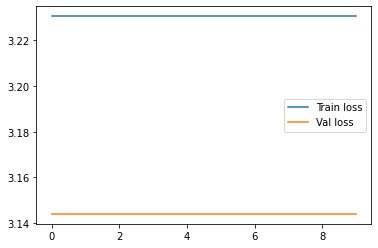

In [57]:
import matplotlib.pyplot as plt
  
plt.plot([i for i in range(epochs)], train_loss_list, label = "Train loss")
plt.plot([i for i in range(epochs)], val_loss_list, label = "Val loss")
plt.legend()
plt.show()

In [ ]:
## Task  ##

In [11]:
## Model Definition ##

In [12]:
## LOSS Definition ##

In [13]:
## Build Sample Selector ##

In [14]:
## Training ##

In [15]:
## Evaluation ##